In [1]:
#==============================================================================
import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu0,floatX=float32"

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pdb
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, Activation
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras import backend as K
from matplotlib import pyplot as plt
%matplotlib inline
import scipy
from sklearn.model_selection import ShuffleSplit
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom
from scipy.ndimage import imread
import time
import datetime

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX TITAN X (CNMeM is enabled with initial size: 20.0% of memory, cuDNN 5110)


### settings

In [3]:
norm_type='zeroMeanUnitStd'
#norm_type='minus1plus1'
#norm_type=None

## utilities

In [4]:
def get_images(df):
    '''Create 3-channel 'images'. Return rescale-normalised images.'''
    images = []
    for i, row in df.iterrows():
        # Formulate the bands as 75x75 arrays
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        #band_3 = band_1 / band_2

        # Rescale
        band_1 = (band_1 - band_1.min()) / (band_1.max() - band_1.min())
        band_2 = (band_2 - band_2.min()) / (band_2.max() - band_2.min())
        #b = (band_3 - band_3.min()) / (band_3.max() - band_3.min())

        b1b2 = np.dstack((band_1, band_2)).astype('float32')
        images.append(b1b2)
    images=np.array(images,'float32')
    images=np.transpose(images,(0,3,1,2))
    return images

def array_stats(X):
    X=np.asarray(X)
    print ('array shape and type: ',X.shape, X.dtype)
    #print 'min: %.3f, max:%.3f, avg: %.3f, std:%.3f' %(np.min(X),np.max(X),np.mean(X),np.std(X))
    print ('min: {}, max: {}, avg: {:.3}, std:{:.3}'.format( np.min(X),np.max(X),np.mean(X),np.std(X)))
    
    
def preprocess(X,xnormType=None):
    if xnormType=='minus1plus1':
        X=X.astype('float32')
        X/=np.max(X)
        X-=0.5
        X=X*2
    elif xnormType=='zeroMeanUnitStd':
        X=X.astype('float32')
        # we do this per channel
        for c in range(X.shape[1]):
            X[:,c]-=np.mean(X[:,c])
            stdXc=np.std(X[:,c])
            if stdXc>0.0:
                X[:,c]/=stdXc
    else:
        print('no normalization!')
    return X
    
# train test model
def train_test_model(X_train,y_train,X_test,y_test,params_train):
    foldnm=params_train['foldnm']  
    pre_train=params_train['pre_train'] 
    batch_size=params_train['batch_size'] 
    augmentation=params_train['augmentation'] 
    path2weights=params_train['path2weights'] 
    print('batch_size: %s, Augmentation: %s' %(batch_size,augmentation))
    
    print 'fold %s training in progress ...' %foldnm
    # load last weights
    if pre_train== True:
        if  os.path.exists(path2weights):
            model.load_weights(path2weights)
            print 'previous weights loaded!'
        else:
            raise IOError('weights does not exist!!!')
    else:
        if  os.path.exists(path2weights):
            model.load_weights(path2weights)
            print (path2weights)
            print ('previous weights loaded!')
            train_status='previous weights'
            return train_status
    
    # path to csv file to save scores
    path2scorescsv = weightfolder+'/scores.csv'
    first_row = 'train,test'
    with open(path2scorescsv, 'w+') as f:
        f.write(first_row + '\n')
           
    # Fit the model
    start_time=time.time()
    scores_test=[]
    scores_train=[]
    if params_train['loss']=='dice': 
        best_score = 0
        previous_score = 0
    else:
        best_score = 1e6
        previous_score = 1e6
    patience = 0
    
    # convert class vectors to binary class matrices
    #y_train = np_utils.to_categorical(y_train, nb_outputs)
    #y_test = np_utils.to_categorical(y_test, nb_outputs)
    
    
    for epoch in range(params_train['nbepoch']):
    
        print ('epoch: %s,  Current Learning Rate: %.1e' %(epoch,model.optimizer.lr.get_value()))
        #seed = np.random.randint(0, 999999)
    
        if augmentation:
            batches=0
            bs=len(X_train)#batch_size*10
            for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=bs,shuffle=True):
                X_batch=preprocess(X_batch,norm_type)
                hist=model.fit(X_batch, y_batch, batch_size=batch_size,nb_epoch=1, verbose=0)
                batches += 1
                if batches >= len(X_train) / bs:
                    # we need to break the loop by hand because
                    # the generator loops indefinitely
                    break
        else:
            hist=model.fit(preprocess(X_train,norm_type)[:,:,np.newaxis], y_train, batch_size=batch_size,nb_epoch=1, verbose=0)
            
        # evaluate on test and train data
        score_test=model.evaluate(preprocess(X_test,norm_type),y_test,verbose=0)
        score_train=np.mean(hist.history['loss'])
       
        print ('score_train: %s, score_test: %s' %(score_train,score_test))
        scores_test=np.append(scores_test,score_test)
        scores_train=np.append(scores_train,score_train)    

        # check for improvement    
        if (score_test<=best_score):
            print ("!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!") 
            best_score = score_test
            patience = 0
            model.save_weights(path2weights)  
            model.save(weightfolder+'/model.h5')
            
        # learning rate schedule
        if score_test>previous_score:
            #print "Incrementing Patience."
            patience += 1

        # learning rate schedule                
        if patience == params_train['max_patience']:
            params_train['learning_rate'] = params_train['learning_rate']/2
            print ("Upating Current Learning Rate to: ", params_train['learning_rate'])
            model.optimizer.lr.set_value(params_train['learning_rate'])
            print ("Loading the best weights again. best_score: ",best_score)
            model.load_weights(path2weights)
            patience = 0
        
        # save current test score
        previous_score = score_test    
        
        # store scores into csv file
        with open(path2scorescsv, 'a') as f:
            string = str([score_train,score_test])
            f.write(string + '\n')
           
    
    print ('model was trained!')
    elapsed_time=(time.time()-start_time)/60
    print ('elapsed time: %d  mins' %elapsed_time)      

    # train test progress plots
    plt.figure(figsize=(10,10))
    plt.plot(scores_test)
    plt.plot(scores_train)
    plt.title('train-validation progress',fontsize=20)
    plt.legend(('test','train'),fontsize=20)
    plt.xlabel('epochs',fontsize=20)
    plt.ylabel('loss',fontsize=20)
    plt.grid(True)
    plt.savefig(weightfolder+'/train_val_progress.png')
    #plt.show()
    
    print 'training completed!'
    train_status='completed!'
    return train_status     

### loading data

In [5]:
train = pd.read_json('../data/train.json')
X=get_images(train)
array_stats(X)

# labels
#y = to_categorical(train.is_iceberg.values,nb_classes=2)
y = train.is_iceberg.values

('array shape and type: ', (1604, 2, 75, 75), dtype('float32'))
min: 0.0, max: 1.0, avg: 0.384, std:0.142


#### visualize data

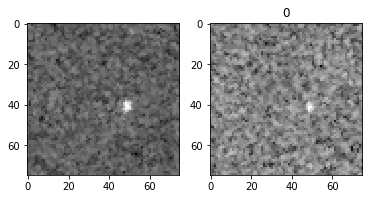

In [6]:
n1=np.random.randint(len(X))
plt.subplot(1,2,1)
plt.imshow(X[n1,0],cmap='gray');
plt.subplot(1,2,2)
plt.imshow(X[n1,1],cmap='gray');
plt.title(y[n1]);

In [7]:
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D,Dropout
from keras.layers import Activation,Reshape,Permute,Flatten,Dense
from keras.models import Model,Sequential
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import GRU
from keras.optimizers import RMSprop, Adam,Nadam
from keras.layers import GlobalAveragePooling1D,AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.layers.advanced_activations import ELU,PReLU,LeakyReLU
from keras.preprocessing.image import ImageDataGenerator

def conv_block(x_input, num_filters,pool=True,norm=False,drop_rate=0.0,border_mode='same',stride=1):
    x1 = Convolution2D(num_filters,3,3,subsample=(stride,stride),border_mode=border_mode,W_regularizer=l2(1e-4))(x_input)
    if norm:
        x1 = BatchNormalization(mode=2,axis=1)(x1)
        
    if drop_rate > 0.0:
        x1 = GaussianDropout(drop_rate)(x1)

    x1 = LeakyReLU(.1)(x1)
    if pool:
        x1 = MaxPooling2D()(x1)
    x_out = x1
    return x_out


def modelCnn(params):
    # input format: batch_size*timesteps*z*h*w    
    h=params['h']
    w=params['w']
    z=params['z']
    timesteps=params['timesteps']    
    lr=params['learning_rate']
    nb_output=params['nb_outputs']
    loss=params['loss']
    C=params['init_filters']
    border_mode=params['border_mode']
    base_display=params['base_display']
    stride=params['stride']
    dropOutRate=params['dropOutRate']
    optimizer=params['optimizer']
    kS=params['kernelSize']
    kI=params['kernelInit']
    bnEnable=params['batchNormEnable']
    iF=params['init_filters']
    
    xin = Input((z,h, w))
    x1 = conv_block(xin,C,norm=bnEnable,stride=stride) 
    x1 = conv_block(x1,C,norm=bnEnable,pool=False) 
    #x1_ident = AveragePooling2D(pool_size=(2*stride, 2*stride))(xin)
    #x1_merged = merge([x1, x1_ident],mode='concat', concat_axis=1)
    x1_merged=x1

    x2_1 = conv_block(x1_merged,2*C,norm=bnEnable) 
    x2_1 = conv_block(x2_1,2*C,norm=bnEnable,pool=False) 
    #x2_ident = AveragePooling2D()(x1_ident)
    #x2_merged = merge([x2_1,x2_ident],mode='concat', concat_axis=1)
    x2_merged=x2_1

    #by branching we reduce the #params
    x3_1 = conv_block(x2_merged,4*C,norm=bnEnable) 
    x3_1 = conv_block(x3_1,4*C,norm=bnEnable,pool=False)
    #x3_ident = AveragePooling2D()(x2_ident)
    #x3_merged = merge([x3_1,x3_ident],mode='concat', concat_axis=1)
    x3_merged=x3_1

    x4_1 = conv_block(x3_merged,8*C,norm=bnEnable)
    x4_1 = conv_block(x4_1,8*C,norm=bnEnable,pool=False)
    #x4_ident = AveragePooling2D()(x3_ident)
    #x4_merged = merge([x4_1,x4_ident],mode='concat', concat_axis=1)    
    x4_merged=x4_1

    x5_1 = conv_block(x4_merged,16*C,norm=bnEnable,pool=False)
    x5_1 = conv_block(x5_1,16*C,norm=bnEnable,pool=False)
    
    x=GlobalAveragePooling2D()(x5_1)
    
    # last layer of encoding    
    #x=Flatten() (x5_1)
    #x=Dropout(dropOutRate)(x)
    
    x=Dense(nb_output, activation='sigmoid',W_regularizer=l2(1e-4))(x)
    
    model = Model(input=xin, output=x)
    
    
    if optimizer=='RMSprop':
        optimizer = RMSprop(lr)
    elif optimizer=='Adam':       
        optimizer = Adam(lr)
    elif optimizer=='Nadam':       
        optimizer = Nadam(lr,clipvalue=1.0)        
    model.compile(loss=loss, optimizer=optimizer)

    return model

# random data generator
datagen = ImageDataGenerator(featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        width_shift_range=0.10,
        height_shift_range=0.10,
        shear_range=0.1,
        zoom_range=0.10,
        channel_shift_range=0.0,
        fill_mode='constant',
        cval=0.0,
        horizontal_flip=True,
        vertical_flip=True,
        dim_ordering='th') 


_,z,h,w=X.shape
# training params
params_train={
    'h': h,
    'w': w,
    'z': z,
    'timesteps':None,
    'c':1,           
    'learning_rate': 3e-4,
    #'optimizer': 'Adam',
    'optimizer': 'Nadam',
    #'loss': 'categorical_crossentropy',
    'loss': 'binary_crossentropy',
    #'loss': 'mean_squared_error',
    'nbepoch': 500,
    'nb_outputs': 1,
    'init_filters': 32,    
    'max_patience': 30,
    'stride': 1,
    'fully_connected': False,
    'output_activation': 'sigmoid',
    'border_mode':'valid',
    'base_display': True,
    'dropOutRate': 0.0,
    'pre_train': False,
    'foldnm':1,
    'kernelSize':3,
    'kernelInit':'glorot_uniform',
    'batchNormEnable': True,
    'batch_size': 128,
    'augmentation': True,
    'path2weights': None,
}    


model=modelCnn(params_train)
model.summary()

/home/mra/anaconda2/lib/python2.7/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode='max')
/home/mra/anaconda2/lib/python2.7/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode='max')
/home/mra/anaconda2/lib/python2.7/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode='max')


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 2, 75, 75)     0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 32, 75, 75)    608         input_1[0][0]                    
____________________________________________________________________________________________________
batchnormalization_1 (BatchNormal(None, 32, 75, 75)    64          convolution2d_1[0][0]            
____________________________________________________________________________________________________
leakyrelu_1 (LeakyReLU)          (None, 32, 75, 75)    0           batchnormalization_1[0][0]       
___________________________________________________________________________________________

### get current notebook name

In [8]:
#%%javascript
#var kernel = IPython.notebook.kernel;
#var thename = window.document.getElementById("notebook_name").innerHTML;
#var command = "theNotebook = " + "'"+thename+"'";
#kernel.execute(command)

wait ...
fold 1
('array shape and type: ', (1443, 2, 75, 75), dtype('float32'))
min: 0.0, max: 1.0, avg: 0.384, std:0.143
('array shape and type: ', (1443,), dtype('int64'))
min: 0, max: 1, avg: 0.456, std:0.498
('array shape and type: ', (161, 2, 75, 75), dtype('float32'))
min: 0.0, max: 1.0, avg: 0.386, std:0.139
('array shape and type: ', (161,), dtype('int64'))
min: 0, max: 1, avg: 0.59, std:0.492
------------------------------
experiment: trainTest5_hw_75by75_initfilts_32
weights folder created
batch_size: 128, Augmentation: True
fold 1 training in progress ...
./output/weights/trainTest5_hw_75by75_initfilts_32/fold1/weights.hdf5
previous weights loaded!
./output/weights/trainTest5_hw_75by75_initfilts_32/fold1/weights.hdf5 loaded!
score_test: 0.26823
------------------------------
fold 2
('array shape and type: ', (1443, 2, 75, 75), dtype('float32'))
min: 0.0, max: 1.0, avg: 0.383, std:0.142
('array shape and type: ', (1443,), dtype('int64'))
min: 0, max: 1, avg: 0.457, std:0.498


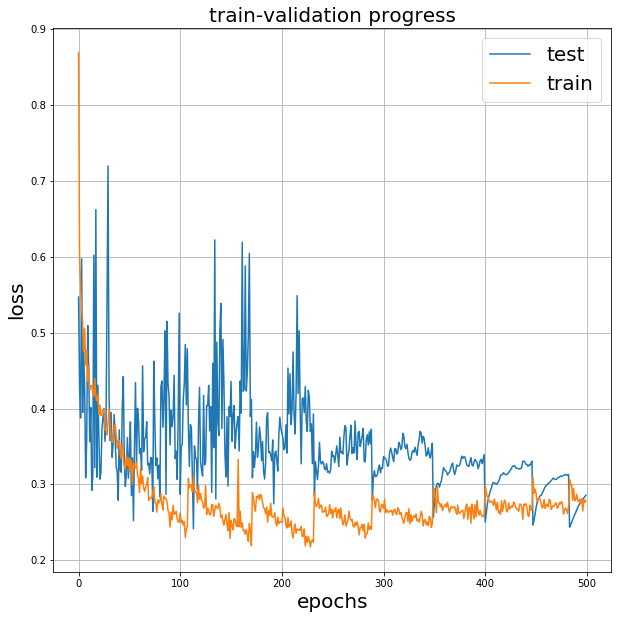

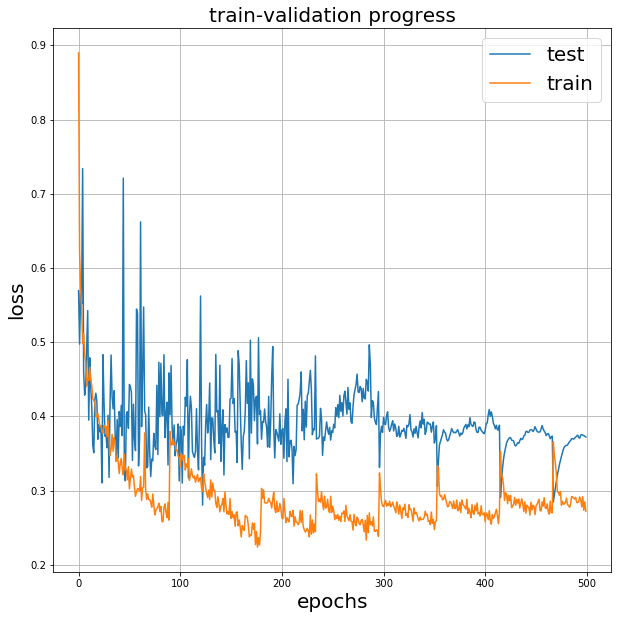

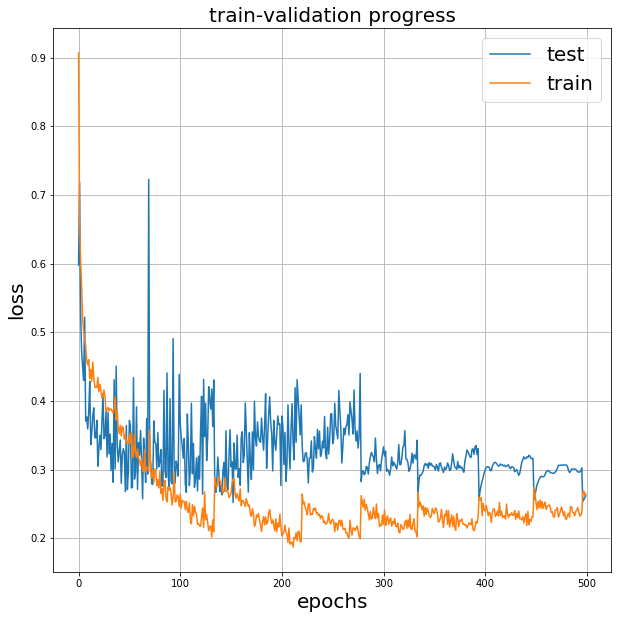

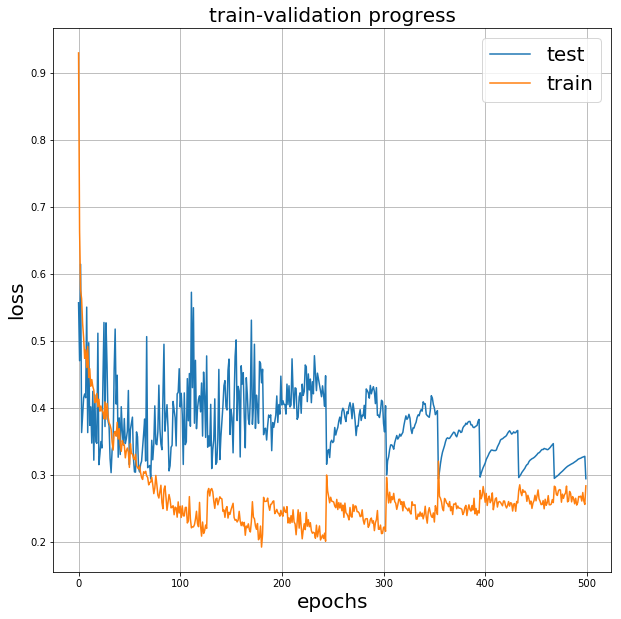

In [9]:
n_folds=5
#skf = StratifiedKFold(n_splits=5,random_state=123,shuffle=True)
#skf = KFold(n_splits=n_folds,random_state=234)
skf = ShuffleSplit(n_splits=n_folds, test_size=0.1, random_state=321)

# loop over folds
foldnm=0
scores_nfolds=[]

print ('wait ...')
for train_ind, test_ind in skf.split(X,y):
    foldnm+=1    
    print('fold %s' %foldnm)

    train_ind=list(np.sort(train_ind))
    test_ind=list(np.sort(test_ind))
    #print test_ind

    X_train,y_train=X[train_ind],y[train_ind]       
    X_test,y_test=X[test_ind],y[test_ind] 
    
    
    array_stats(X_train)
    array_stats(y_train)
    array_stats(X_test)
    array_stats(y_test)
    print ('-'*30)
    
    # exeriment name to record weights and scores
    netinfo='trainTest5'
    experiment=netinfo+'_hw_'+str(h)+'by'+str(w)+'_initfilts_'+str(params_train['init_filters'])
    print ('experiment: %s' %experiment)

    # checkpoint
    weightfolder='./output/weights/'+experiment+'/fold'+str(foldnm)
    if  not os.path.exists(weightfolder):
        os.makedirs(weightfolder)
    print ('weights folder created')    
    
    # path to weights
    path2weights=weightfolder+"/weights.hdf5"
    path2model=weightfolder+"/model.hdf5"    
    
   # training params
    params_train['foldnm']=foldnm
    params_train['learning_rate']=3e-4
    params_train['path2weights']=path2weights
    model=modelCnn(params_train)
    #model.summary()

    
    # train test on fold #
    train_test_model(X_train,y_train,X_test,y_test,params_train)
    
    # loading best weights from training session
    if  os.path.exists(path2weights):
        model.load_weights(path2weights)
        print ('%s loaded!' %path2weights)
    else:
        raise IOError('weights does not exist!!!')

    score_test=model.evaluate(preprocess(X_test,norm_type),y_test,verbose=0)
    print ('score_test: %.5f' %(score_test))    
    print ('-' *30)
    # store scores for all folds
    scores_nfolds.append(score_test)

print ('average score for %s folds is %s' %(n_folds,np.mean(scores_nfolds)))    

## loading leaderboard data

In [10]:
# leaderboard
learder = pd.read_json('../data/test.json')
X_lb = get_images(learder )
array_stats(X_lb)

('array shape and type: ', (8424, 2, 75, 75), dtype('float32'))
min: 0.0, max: 1.0, avg: 0.361, std:0.137


In [11]:
# prediction for nfolds
y_pred=[]
for foldnm in range(1,n_folds+1):
    
    # load weights
    experiment=netinfo+'_hw_'+str(h)+'by'+str(w)+'_initfilts_'+str(params_train['init_filters'])
    print ('experiment:', experiment)
    weightfolder='./output/weights/'+experiment+'/fold'+str(foldnm)
    # path to weights
    path2weights=weightfolder+"/weights.hdf5"
    if  os.path.exists(path2weights):
        model.load_weights(path2weights)
        print ('%s loaded!' %path2weights)
    else:
        raise IOError ('weights does not exist!')

    # prediction
    y_pred_perfold=model.predict(preprocess(X_lb,norm_type))
    print y_pred_perfold.shape    
    y_pred.append(y_pred_perfold)        
        
# reshape 
y_pred1=np.array(y_pred)
y_pred2=np.mean(y_pred1,axis=0)

r1,c1=y_pred2.shape
print y_pred2[0:5]
print (r1,c1)
pred=np.reshape(y_pred2,(r1*c1,1))[:,0]
print (pred.shape)

('experiment:', 'trainTest5_hw_75by75_initfilts_32')
./output/weights/trainTest5_hw_75by75_initfilts_32/fold1/weights.hdf5 loaded!
(8424, 1)
('experiment:', 'trainTest5_hw_75by75_initfilts_32')
./output/weights/trainTest5_hw_75by75_initfilts_32/fold2/weights.hdf5 loaded!
(8424, 1)
('experiment:', 'trainTest5_hw_75by75_initfilts_32')
./output/weights/trainTest5_hw_75by75_initfilts_32/fold3/weights.hdf5 loaded!
(8424, 1)
('experiment:', 'trainTest5_hw_75by75_initfilts_32')
./output/weights/trainTest5_hw_75by75_initfilts_32/fold4/weights.hdf5 loaded!
(8424, 1)
('experiment:', 'trainTest5_hw_75by75_initfilts_32')
./output/weights/trainTest5_hw_75by75_initfilts_32/fold5/weights.hdf5 loaded!
(8424, 1)
[[ 0.11186378]
 [ 0.70218164]
 [ 0.2870664 ]
 [ 0.99648589]
 [ 0.16433708]]
(8424, 1)
(8424,)


### create submission

In [12]:
submissionFolder='./output/submissions'
if not os.path.exists(submissionFolder):
        os.mkdir(submissionFolder)

        
submission = pd.DataFrame({'id': learder['id'], 'is_iceberg': pred})
now = datetime.datetime.now()
info=experiment
suffix = info + '_' + str(now.strftime("%Y-%m-%d-%H-%M"))
path2submission = os.path.join('./output/submissions', 'submission_' + suffix + '.csv')
print (path2submission)
submission.to_csv(path2submission, index=False)
submission.head()

./output/submissions/submission_trainTest5_hw_75by75_initfilts_32_2017-12-17-23-10.csv


,id,is_iceberg
0,5941774d,0.111864
1,4023181e,0.702182
2,b20200e4,0.287066
3,e7f018bb,0.996486
4,4371c8c3,0.164337
